L’exercice proposé ci-dessous est basé sur un problème de recalage de modèle à partir de mesures de rigidités transversales pour des enveloppes poids lourd. Les données sont mises à disposition dans les fichiers « 315 80 R 22.5.txt, 385 55 R 22.5.txt, 495 45 R 22.5.txt » avec 3 colonnes : 
- Charge (noté $Fz$) en Newton,
- Pression (noté $P$) en Bar,
- Rigidité (noté $Dz$) en N/°. 

Les coefficients à optimiser sont notés $a1, a2, a3, a4$ et $a5$. Le modèle à ajuster est le suivant :

$ \displaystyle Dz = (a1 \times P + a2) \times \sin \left(a3 \times \arctan{\left(\frac{Fz}{a4 \times P + a5}\right)} \right)$

Cet exercice est séparé en dex parties. La première consiste à résoudre le problème d'identification de paramètres en utilisant des outils classiques d'optimisation. La seconde vise à trouver les solutions via une approche d'optimisation bayesienne.

## Identification par Optimisation Classique

### Chargement des Données

Veuillez tout d'abord charger les mesures de rigidités de dérive contenues dans le fichier " 315 80 R 22.5.txt".

In [21]:
import numpy as np
import scipy as sp
from scipy import linalg as LA
from scipy.optimize import leastsq as LB
import matplotlib.pyplot as plt
import random

from google.colab import drive
drive.mount('/content/drive')

chemin = '/content/drive/MyDrive/Michelin/Sujet 4/OptimisationBayesienne/Test1.txt'

mat = np.loadtxt(chemin)
z = mat[:,0]   # N
p  = mat[:,1]   # Bar
dz = mat[:,2]   # N/°

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Ces mesures correspondents à des valeurs de rigidités de dérive pour trois niveaux de pression 7, 8.5 et 9.5 bars. Chaque palier de pression comporte 7 points de mesure.
Afficher les mesures $Dz(Fz)$ pour chaque palier de pression

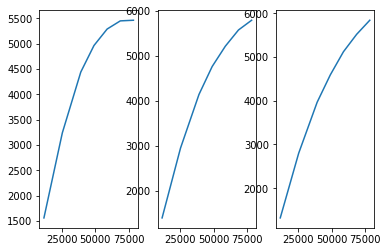

In [22]:
# Affichage des Mesures
plt.subplot(1,3,1)
plt.plot(z[:7], dz[:7])

plt.subplot(1,3,2)
plt.plot(z[7:14], dz[7:14])

plt.subplot(1,3,3)
plt.plot(z[14:], dz[14:])

plt.show()

### Estimation des Valeurs Initiales

L’exercice est un problème d’optimisation continue, non linéaire et sans contrainte. Il est donc nécessaire d'initialiser les paramètres afin de pouvoir lancer un algorithme d'optimisation type recherche linéaire ou région de confiance.

Comment, à votre avis, peut-on essayer d’estimer les coefficients du modèle à partir des mesures ? Pour vous aider, n’oubliez pas que la fonction sinus est bornée. De plus, cadeau, je vous conseille d’approcher a3 par la valeur 2. Il vous reste seulement 4 petits coef à trouver…

Second conseil, le modèle peut également s’écrire sous la forme suivante, idéale quand on connaît déjà $a1, a2$ et $a3$, avec quelques restrictions cependant sur le domaine de définition des fonctions $1/x$, $\arctan$ et $\arcsin$:

$ \displaystyle a4 \times P + a5 = \frac{Fz}{\tan \left(\frac{1}{3} \times \arcsin\left(\frac{Dz}{a1 \times P + a2} \right) \right)}$

Pour estimer les coefficients du modèle à partir des mesures, nous avons choisi d'utiliser une regression linéaire en deux partie.
Dans un premier temps on estime a1 et a2. 

Fz est très grand, ainsi arctan tend vers pi/2 donc sinus(pi) qui tend vers 0 

$ \displaystyle Dz = (a1 \times P + a2) \times \sin \left(a3 \times \arctan{\left(\frac{Fz}{a4 \times P + a5}\right)} \right)$



Donc nous avons approximé le sinus par 0.1

$ \displaystyle \frac{Dz}{0.1} = a1 \times P + a2 $

Puis à partir des estimations de a1 et a2 nous avons estimé a4 et a5 avce la formule :

$ \displaystyle a4 \times P + a5 = \frac{Fz}{\tan \left(\frac{1}{3} \times \arcsin\left(\frac{Dz}{a1 \times P + a2} \right) \right)}$


In [23]:
#On importe LinearRegression car nous allons faire une regression linéaire pour estimer les coefficients
from sklearn.linear_model import LinearRegression  

#On reshape nos données pour que LinearRegression puisse fonctionner correctement
dz = dz.reshape(-1, 1)
p = p.reshape(-1, 1)
z = z.reshape(-1, 1)

# Estimation initiale de a1 et a2
modelReg = LinearRegression()
#Pour faire tendre le sinus vers 0, on prend les trois plus grande valeur de chaque palier de pression 
#4, 5, 6 pour le premier palier de pression allant de 0 à 6 et ainsi de suite pour les autres paliers
ListNum=[4,5,6,11,12,13,18,19,20]
modelReg.fit(p[ListNum],dz[ListNum]/0.1)
print("a1 :",modelReg.coef_, "a2 :",modelReg.intercept_)

# Estimation initiale de a4 et a5
modelReg2 = LinearRegression()
#Dans ce cas la, on a pas d'estimation à faire donc on prend toutes les valeurs
modelReg2.fit(p[:],z[:]/(np.tan((1/3)*np.arcsin(dz[:]/(modelReg.coef_*p[:]+modelReg.intercept_)))))
print("a4 :",modelReg2.coef_, "a5 :", modelReg2.intercept_)

a1 : [[427.63525499]] a2 : [51157.5243779]
a4 : [[52208.24532651]] a5 : [1298530.24486653]


Superposer les courbes de mesures et de prédictions obtenues avec l'initialisation trouvée. Que constatez-vous?

In [24]:
# Fonction permettant de simuler le modèle
# Entrées: paramètres du modèle
# Return: la valeur de Dz 

def Dz(z, a1, a2, a3, a4, a5, P):
  return (a1*P+a2)*np.sin(a3*np.arctan(z/(a4*P+a5)))

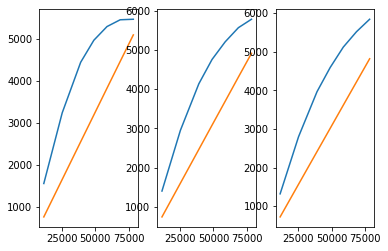

In [25]:
# Affichage de la superposition mesures/prédictions
#Superposition du premier palier mesures/prédictions
plt.subplot(1,3,1)
plt.plot(z[:7], dz[:7])
plt.plot(z[:7], Dz(z[:7],modelReg.coef_,modelReg.intercept_,2,modelReg2.coef_,modelReg2.intercept_,p[:7]))

#Superposition du second palier mesures/prédictions
plt.subplot(1,3,2)
plt.plot(z[7:14], dz[7:14])
plt.plot(z[7:14], Dz(z[7:14],modelReg.coef_,modelReg.intercept_,2,modelReg2.coef_,modelReg2.intercept_,p[7:14]))

#Superposition du troisième palier mesures/prédictions
plt.subplot(1,3,3)
plt.plot(z[14:], dz[14:])
plt.plot(z[14:], Dz(z[14:],modelReg.coef_,modelReg.intercept_,2,modelReg2.coef_,modelReg2.intercept_,p[14:]))

plt.show()

Nous constatons que l'estimation de nos paramétres donne une droite qui ne prend en compte la courbure des mesures. 

### Fine Tuning des valeurs

Dans le but d'affiner les valeurs obtenues à l'issue de la phase d'initialisation, il est nécessaire de faire appel à un algorithme d'optimisation non linéaire.

En l'occurence, il s'agit d'un problème de curve fitting. 

Quel critère est-il pertinent de considérer? 

Quel type d'algorithme peut-on mettre en oeuvre? 

Implémenter l'optimisation des valeurs des coefficients.

In [26]:
# Fonction permettant de calculer la fonction coût
# Entrées: paramètres à optimiser
# Return: la valeur du critère à optimiser 

def funccost(x, a1, a2, a3, a4, a5):
    return ((a1*x[1]+a2)*np.sin(a3*np.arctan(x[0]/(a4*x[1]+a5))))

In [27]:
#On importe curve_fit afin de resoudre le problème de curve fitting
from scipy.optimize import curve_fit

#En raison des problèmes de changement de taille sur nos variables, 
#nous avons retélécharger les données de départ
mat = np.loadtxt(chemin)
z = mat[:,0]   # N
p  = mat[:,1]   # Bar
dz = mat[:,2]   # N/°

# Optimisation des paramètres
params=[modelReg.coef_, modelReg.intercept_ , 2.0, modelReg2.coef_, modelReg2.intercept_]
#On transforme touts nos paramètres présent dans la liste params en float
#pour que curve_fit fonctionne correctement
params=np.array(params,dtype='float64')
result= curve_fit(funccost, (z,p), dz, p0=params)
print(result[0][0], result[0][1], result[0][2], result[0][3], result[0][4])

240.02457361692993 3801.9222184378327 2.0731384201081093 12059.616551657917 -3616.944527101399


<ipython-input-27-8f472d9decbf>:15: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  params=np.array(params,dtype='float64')


Superposer les courbes de mesures et de prédictions obtenues avec les valeurs finales trouvées. A-t-on améliorer la qualité de prédiction du modèle par rapport à la phase d'initialisation? Comment peut-on le quantifier?

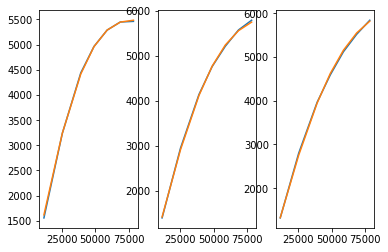

In [28]:
# Affichage de la superposition mesures/prédictions avec les nouvelles valeurs optimisées des paramètres
#Superposition du premier palier mesures/prédictions
plt.subplot(1,3,1)
plt.plot(z[:7], dz[:7])
plt.plot(z[:7], Dz(z[:7],result[0][0],result[0][1],result[0][2],result[0][3],result[0][4],p[:7]))

#Superposition du second palier mesures/prédictions
plt.subplot(1,3,2)
plt.plot(z[7:14], dz[7:14])
plt.plot(z[7:14], Dz(z[7:14],result[0][0],result[0][1],result[0][2],result[0][3],result[0][4],p[7:14]))

#Superposition du troisième palier mesures/prédictions
plt.subplot(1,3,3)
plt.plot(z[14:], dz[14:])
plt.plot(z[14:], Dz(z[14:],result[0][0],result[0][1],result[0][2],result[0][3],result[0][4],p[14:]))

plt.show()

Les resultats obtenus aprés le curve fitting donne une meilleure estimation des mesures comme nous pouvons le voir à la superposition des courbes sur les graphiques.


In [29]:
#On importe mean_absolute_error pour pouvoir calculer les différentes erreurs de chaque méthodes
from sklearn.metrics import mean_absolute_error

print("MAE : curve_fitting :",mean_absolute_error(dz,funccost([z,p], result[0][0],result[0][1],result[0][2],result[0][3],result[0][4])))
print("MAE : linear_regression :",mean_absolute_error(dz,funccost([z,p], modelReg.coef_[0],modelReg.intercept_[0],2.0,modelReg2.coef_[0],modelReg2.intercept_[0])))

MAE : curve_fitting : 22.39623110854912
MAE : linear_regression : 1269.4865955679388


A partir des courbes et des résultats d'erreur, nous pouvons clairement nous rendre compte que la seconde méthode, celle utilisant le Curve Fitting, est beaucoup plus précise que notre première méthode utilisant la Regression Linéaire

## Identification par Optimisation Bayesienne

Comme précisé plus haut, cette partie vise à résoudre le problème d'identification via une approche bayesienne. Pour ce faire, nous allons nous appuyer sur le package python scikit-optimize (https://scikit-optimize.github.io/stable/).

In [30]:
#On installe le package python scikit-optimize
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
#On importe 
from skopt.plots import plot_gaussian_process, plot_convergence

### Premier Essai

Nous travaillons toujours avec la même fonction objectif utilisée dans la première partie du TP. On va considérer de plus les bornes suivantes:
- $200 \leq a1 \leq 300$
- $3000 \leq a2 \leq 4500$
- $1 \leq a3 \leq 3$
- $1e4 \leq a4 \leq 2e4$
- $-5e3 \leq a5 \leq -2e3$

La fonction d'acquisition qui sera utilisée dans un premier temps est l'amélioration espérée (Expected Improvement). Nous fixerons le nombre d'appels à la fonction coût originale à 100. Enfin, on utilise un plan de type LHS avec 50 points pour construire le modèle de krigeage avant la permière minimisation de la fonction d'acquisition.

A l'aide de la documentation du package scikit-optimize, implémenter cette première tentative d'optimisation bayesienne et visualiser le graphe de convergence. A-t-on le même niveau de convergence qu'observé dans la première section du TP? Comment pourrait-on améliorer la convergence?

In [32]:
# Fonction permettant de calculer la fonction coût au format attendu par scikit-optimize
# Entrées: paramètres à optimiser
# Return: la valeur du critère à optimiser 
def funccost2(x):
    return mean_absolute_error(dz,funccost([z,p], x[0], x[1], x[2], x[3], x[4]))

In [33]:
#On importe Real pour récuperer la dimension de l'espace de recherche 
#qui peut prendre n'importe quelle valeur réelle
from skopt.space import Real

# Définition des bornes
svc_search  = [Real(200, 300, name='a1'),
          Real(3000, 4500, name='a2'),
          Real(1, 3, name='a3'),
          Real(1e4, 2e4, name='a4'),
          Real(-5e3, -2e3, name='a5')]


In [34]:
#On importe gp_minimize pour pouvoir estimer les paramètres par optimisation bayésienne
from skopt import gp_minimize

# Estimation des paramètres par optimisation bayesienne
res = gp_minimize(funccost2,                  # la fonction à minimiser
                  svc_search,                 # les bornes de chaques dimensions de x
                  acq_func="EI",              # la fonction d'acquisition
                  n_calls=100,
                  n_initial_points=50,
                  initial_point_generator='lhs')
print(res.x)

[213.00132585319244, 3939.4088100338845, 2.7712884611186936, 15884.602745071283, -2000.0]


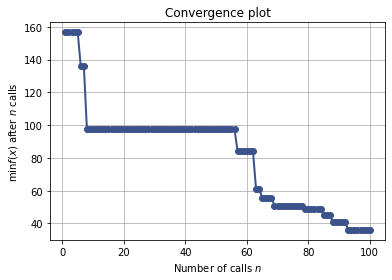

In [35]:
# Affichage de l'évolution de la fonction coût au fil des itérations via la fonction "plot_convergence" de scikit-optimize
plot_convergence(res);

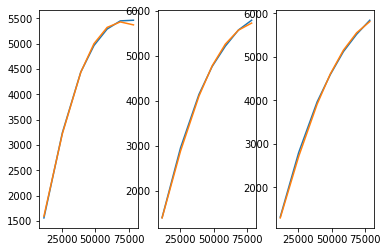

MAE : 36.05557067333218


In [36]:
# Fonction permettant d'afficher la superposition mesures/prédictions avec les nouvelles valeurs optimisées des paramètres
# Entrées: fonction coût, rigidité, charge, fonction rigidité, pression
def affiche(res,dz,z,Dz,p):

  plt.subplot(1,3,1)
  plt.plot(z[:7], dz[:7])
  plt.plot(z[:7], Dz(z[:7],res.x[0],res.x[1],res.x[2],res.x[3],res.x[4],p[:7]))

  plt.subplot(1,3,2)
  plt.plot(z[7:14], dz[7:14])
  plt.plot(z[7:14], Dz(z[7:14],res.x[0],res.x[1],res.x[2],res.x[3],res.x[4],p[7:14]))

  plt.subplot(1,3,3)
  plt.plot(z[14:], dz[14:])
  plt.plot(z[14:], Dz(z[14:],res.x[0],res.x[1],res.x[2],res.x[3],res.x[4],p[14:]))

  plt.show()

affiche(res,dz,z,Dz,p)

print("MAE :",mean_absolute_error(dz,Dz(z, res.x[0],res.x[1],res.x[2],res.x[3],res.x[4],p)))

### Amélioration de la configuration de l'algorithme

Essayer différents nombres de points d'évaluation et les fonctions d'acquisition PI et LCB pour tenter d'améliorer le paramétrage de l'algorithme. A partir de l'analyse des graphiques de convergence et de fonctions d'acquisition, quelle est la configuration la plus efficiente?

pe= 25 acq_func= PI 

MAE : 27.268720791231523


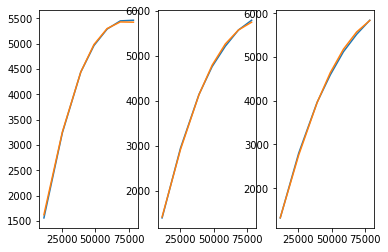

pe= 25 acq_func= LCB 

MAE : 39.26332663943678


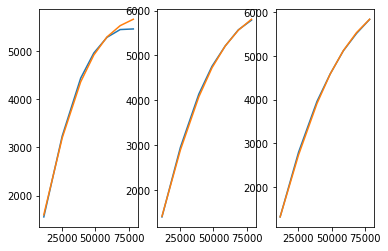

pe= 50 acq_func= PI 

MAE : 38.55052046449492


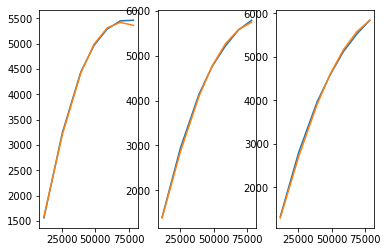

pe= 50 acq_func= LCB 

MAE : 32.894432453654105


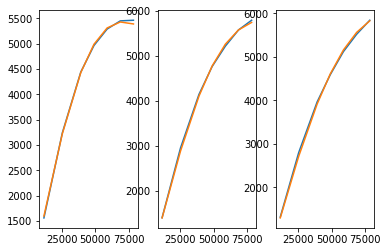

pe= 75 acq_func= PI 

MAE : 36.730341750351684


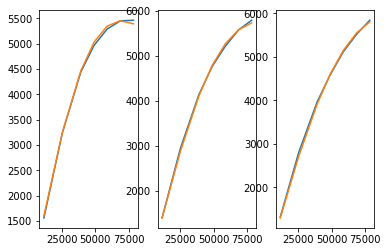

pe= 75 acq_func= LCB 

MAE : 60.80252155276075


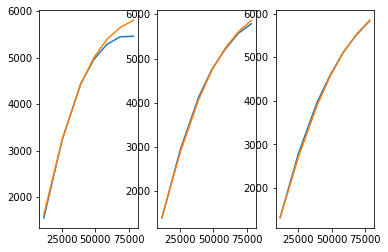

pe= 100 acq_func= PI 

MAE : 94.0672639191305


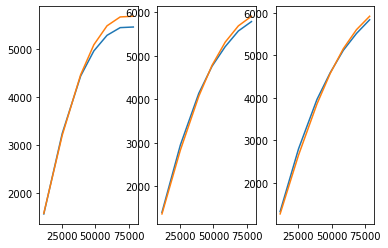

pe= 100 acq_func= LCB 

MAE : 95.67902066579475


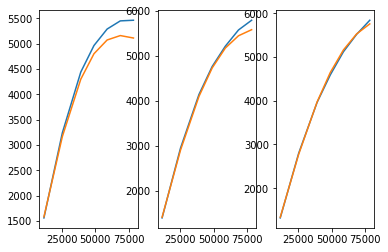

[290.13081722152083, 3130.3113078561173, 2.4053499955199253, 13221.70443859517, -2118.4387596140855]


In [20]:
# Tests et évaluation avec différentes options du solver
pe=[25,50,75,100]
acq_func=["PI","LCB"]

for i in pe:
  for  j in acq_func:
      res = gp_minimize(funccost2,
                  svc_search,       # les bornes de chaques dimensions de x
                  acq_func=j,       # the acquisition function
                  n_calls=100,
                  n_initial_points=i,
                  initial_point_generator='lhs' )
      print("pe=",i,"acq_func=",j,"\n")
      #On calcule l'écart d'erreur entre la courbe bleu (la réelle) et la courbe orange (celle calculé)
      print("MAE :",mean_absolute_error(dz,Dz(z, res.x[0],res.x[1],res.x[2],res.x[3],res.x[4],p)))
      affiche(res,dz,z,Dz,p)      

print(res.x)

A l'aide de l'écart d'erreur calculé entre les prédictions et les valeurs réelles (MAE), on peut déterminer quels sont les paramètres (PI, LCB) qui offrent le plus de précision.
On remarque donc que 25 point d'évaluation et la fonction d'acquisition PI sont les paramètres offrant le plus de précision avec une MAE = 27.

En choisissant l'algorithme de curve fitting comme solution pour définir nos paramètres nous trouvons :

a1 = 240

a2 =  3801

a3 = 2.07

a4 = 12059

a5 = -3616